# Evaluating Cornetto on several semantic measures

Below, I evaluate Cornetto on the following semantic measures:
* Relatedness
* Similarity
* Typicality & Goodness

I have implemented these measures in a module called 'dutch testbench'. The first few cells are to set up this notebook. Scroll down to see the graphs!
    

In [56]:
%matplotlib inline

In [22]:
import pandas
import seaborn as sns
from matplotlib import pyplot as plt

In [42]:
sns.set_style("whitegrid")

In [3]:
import csv, zipfile
from io import StringIO
from dutch_testbench import test_suite

## Loading the Cornetto model

Here I define the class WordNetModel. This class loads similarity data that was generated using Piek Vossen's WordNetTools. In the comparison below I use W&P distance, path distance and L&C distance.

The class has two important methods:
1. Similarity: returns the similarity between two items.
2. Doesn't match: returns the word that is least similar to the other words passed to it.

In [4]:
class WordNetModel(object):
    """Object that loads a list of similarity values, and that has a similar interface
    to a Gensim model."""
    def __init__(self):
        self.simtype = 'Similar by path'
        self.simtypes = {'Similar by W&P', 'Similar by path', 'Similar by L&C'}
        zf      = zipfile.ZipFile('./WordNet-tools/sim-processing/simpairs.txt.all.zip')
        data    = StringIO(zf.read('simpairs.txt.all').decode('utf-8'))
        reader  = csv.DictReader(data, delimiter='\t')
        self.simdict = {(entry['word-1'], entry['word-2']): entry for entry in reader
                        if not entry['Similar by path'] == '-1.0'}
        self.vocab   = {w for pair in self.simdict for w in pair}
        zf.close()
        del data
        del reader
    
    def similarity(self,a,b):
        "Computes the similarity between a and b."
        pair = tuple(sorted([a,b]))
        return float(self.simdict[pair][self.simtype])
    
    def doesnt_match(self, l):
        """Computes similarities between the items in l and return the
        item with the lowest sum of similarities to the other items."""
        words = set(l)
        def sum_of_similarities(i):
            return sum(self.similarity(i,x) for x in (words - {i}) )
        
        return min( (sum_of_similarities(i), i) for i in l)[1]

In [5]:
def evaluate_on_all(model):
    vocab = model.vocab
    results = { 'Relatedness': test_suite.test_relatedness_1(model, vocab),
                'Relatedness-cc': test_suite.test_relatedness_2(model, vocab, variant = 'cross-cat'),
                'Relatedness-ccw': test_suite.test_relatedness_2(model, vocab, variant = 'cross-cat-weighted'),
                'Relatedness-wc': test_suite.test_relatedness_2(model, vocab, variant = 'within-cat'),
                'Relatedness-wcw': test_suite.test_relatedness_2(model, vocab, variant = 'within-cat-weighted'),
                'Similarity1': test_suite.test_similarity_1(model, vocab),
                'Similarity2': test_suite.test_similarity_2(model, vocab),
                'typicality': test_suite.test_typicality(model, vocab),
                'goodness': test_suite.test_goodness(model, vocab),
                }
    return results

In [6]:
model = WordNetModel()

In [49]:
def results_as_df(all_results, exclude={}, getscore=lambda result: result['score']):
    data = {'Model':[], 'Score':[], 'Measure':[]}
    for model, results in all_results.items():
        for measure in results:
            if not measure in exclude:
                data['Model'].append(model)
                data['Score'].append(getscore(results[measure]))
                data['Measure'].append(measure)
    return pandas.DataFrame.from_dict(data)

In [8]:
def get_all_relatedness():
    all_results = dict()
    for simtype in model.simtypes:
        model.simtype = simtype
        all_results[simtype] = evaluate_on_all(model)
    return all_results

In [9]:
all_results = get_all_relatedness()

## First results: relatedness

Here are the relatedness-results:

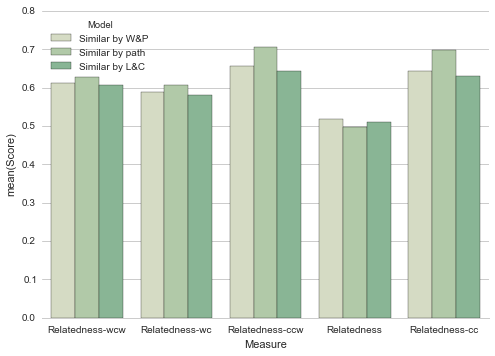

In [50]:
data        = results_as_df(all_results, 
                            exclude={'Similarity1', 'Similarity2', 'typicality', 'goodness'},
                            getscore=lambda result: result['score'])
palette     = sns.cubehelix_palette(8, start=.5, rot=-0.75)
sns.barplot(x="Measure", y="Score", hue="Model", data=data, palette=palette)
sns.despine(left=True)

## More results: Similarity

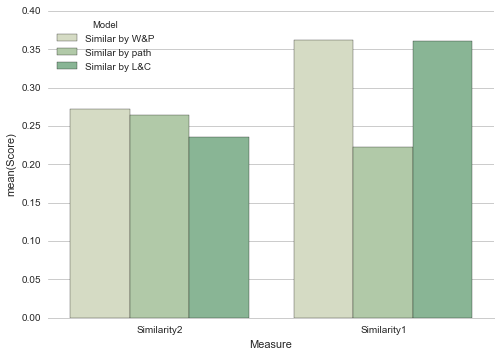

In [54]:
data        = results_as_df(all_results, 
                            exclude={'Relatedness', 'Relatedness-cc', 'Relatedness-ccw', 
                                     'Relatedness-wc', 'Relatedness-wcw', 'typicality', 
                                     'goodness'},
                            getscore=lambda result: result['overall']['spearmanr'][0])
data
palette     = sns.cubehelix_palette(8, start=.5, rot=-0.75)
sns.barplot(x="Measure", y="Score", hue="Model", data=data, palette=palette)
sns.despine(left=True)

## Last result: typicality & goodness

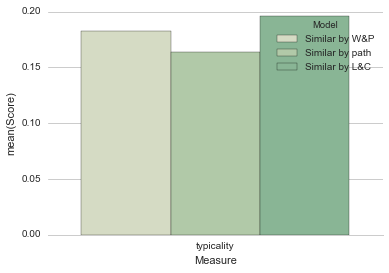

In [59]:
def get_score(result):
    return result['score']

data        = results_as_df(all_results, 
                            exclude={'goodness','Similarity1', 'Similarity2', 'Relatedness', 
                                     'Relatedness-cc', 'Relatedness-ccw', 
                                     'Relatedness-wc', 'Relatedness-wcw',},
                            getscore=get_score)
palette     = sns.cubehelix_palette(8, start=.5, rot=-0.75)
sns.barplot(x="Measure", y="Score", hue="Model", data=data, palette=palette)
sns.despine(left=True)

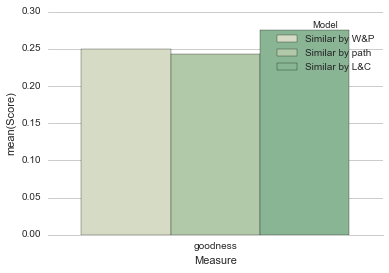

In [61]:
def get_score(result):
    return result['overall']['avg_spearman']

data        = results_as_df(all_results, 
                            exclude={'typicality','Similarity1', 'Similarity2', 'Relatedness', 
                                     'Relatedness-cc', 'Relatedness-ccw', 
                                     'Relatedness-wc', 'Relatedness-wcw',},
                            getscore=get_score)
palette     = sns.cubehelix_palette(8, start=.5, rot=-0.75)
sns.barplot(x="Measure", y="Score", hue="Model", data=data, palette=palette)
sns.despine(left=True)